In [1]:
import numpy as np
import g3_utils as ut
import matplotlib.pyplot as plt
from spt3g import core
import pathlib

In [2]:
control_computer_g3_dir = pathlib.Path("/media/player1/blast2020fc1/blasttng_g3")
roach1_pass3_file = control_computer_g3_dir / "testing/roach1_pass3.g3"

ra_df_added = control_computer_g3_dir / "mapmaking/ra_df_added.g3"
norm_df_added = control_computer_g3_dir / "mapmaking/norm_df_added.g3"

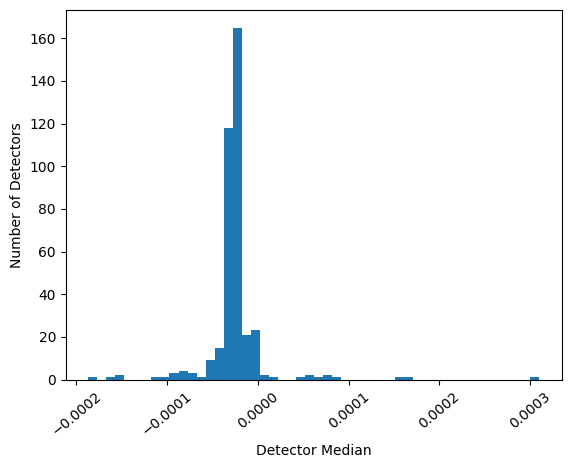

In [3]:
stats = ut.DetectorStats(data_key="df")

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(ra_df_added))
pipe.Add(stats)
pipe.Run()

detector_medians = np.median(np.array(stats.medians), axis=0)
detector_medians.shape
plt.hist(detector_medians, bins=50)
plt.xticks(rotation=40)
plt.xlabel("Detector Median")
plt.ylabel("Number of Detectors")
plt.show()

# detector_stds = np.median(np.array(stats.stds), axis=0)
# detector_stds.shape
# plt.hist(detector_stds, bins=50)
# plt.xticks(rotation=40)
# plt.xlabel("Detector Standard Deviation")
# plt.ylabel("Number of Detectors")
# plt.gca().set_yscale("log")
# plt.show()

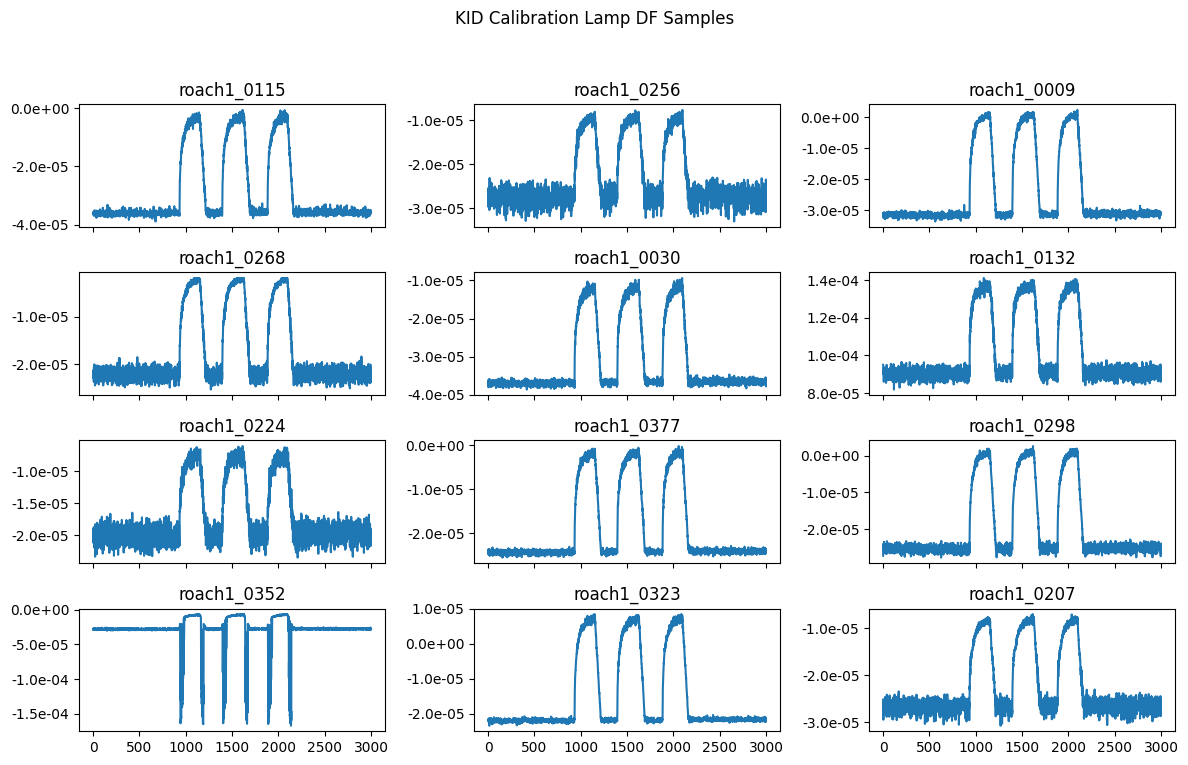

In [4]:
from matplotlib.ticker import FuncFormatter
def sci_notation(x, pos):
    return f'{x:.1e}'

cf_grabber = ut.FirstFrameGrabber(frame_type=core.G3FrameType.Calibration)
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(roach1_pass3_file))
pipe.Add(ut.add_cal_lamp_df, iq_key="cal_lamp_data")
pipe.Add(cf_grabber)
pipe.Run()
calframe = cf_grabber.first_frame

fig, axs = plt.subplots(4, 3, figsize=(12, 8), sharex='all')
fig.suptitle("KID Calibration Lamp DF Samples")
axs = axs.flatten()
for i, sample_idx in enumerate(range(0, 12)):
    name = calframe['cal_lamp_df'].names[sample_idx]
    axs[i].plot(calframe["cal_lamp_df"].data[sample_idx])
    axs[i].set_title(name)
    axs[i].yaxis.set_major_formatter(FuncFormatter(sci_notation))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

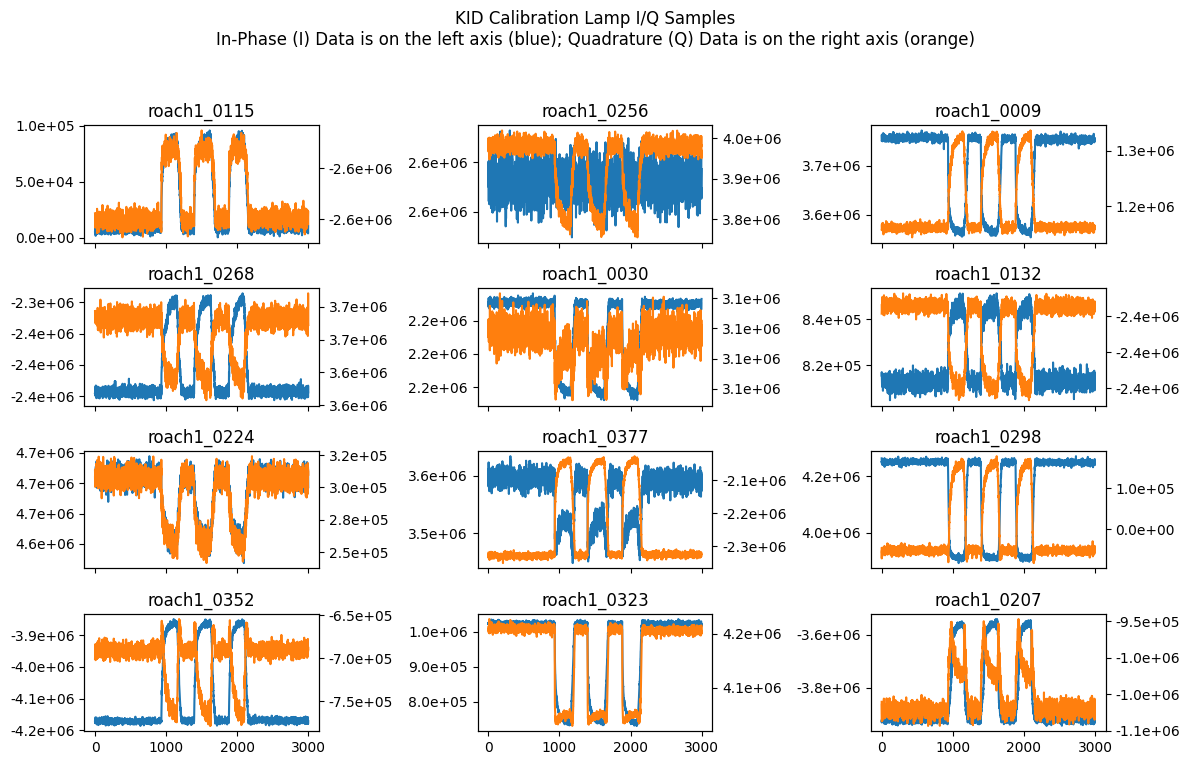

In [5]:
fig, axs = plt.subplots(4, 3, figsize=(12, 8), sharex='all')
fig.suptitle("KID Calibration Lamp I/Q Samples"
            "\nIn-Phase (I) Data is on the left axis (blue); Quadrature (Q) Data is on the right axis (orange)")
axs = axs.flatten()
for i, sample_idx in enumerate(range(0, 12)):
    name = calframe['cal_lamp_df'].names[sample_idx]
    i_key = int(np.where(np.array(calframe["cal_lamp_data"].names) == name+'_I')[0][0])
    q_key = int(np.where(np.array(calframe["cal_lamp_data"].names) == name+'_Q')[0][0])
    axs2 = axs[i].twinx()
    axs[i].plot(calframe["cal_lamp_data"].data[i_key], color='C0')
    axs2.plot(calframe["cal_lamp_data"].data[q_key], color='C1')
    assert ~np.all(np.asarray(calframe["cal_lamp_data"].data[i_key]) == np.asarray(calframe["cal_lamp_data"].data[q_key])), \
        "I/Q data are identical!"
    axs[i].set_title(name)
    axs[i].yaxis.set_major_formatter(FuncFormatter(sci_notation))
    axs2.yaxis.set_major_formatter(FuncFormatter(sci_notation))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [6]:
grabber = ut.FirstFrameGrabber(frame_type=core.G3FrameType.Scan)
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(norm_df_added))
pipe.Add(grabber)
pipe.Run()
first_scan_frame = grabber.first_frame


Calibration
PipelineInfo
Scan (x117)
EndProcessing


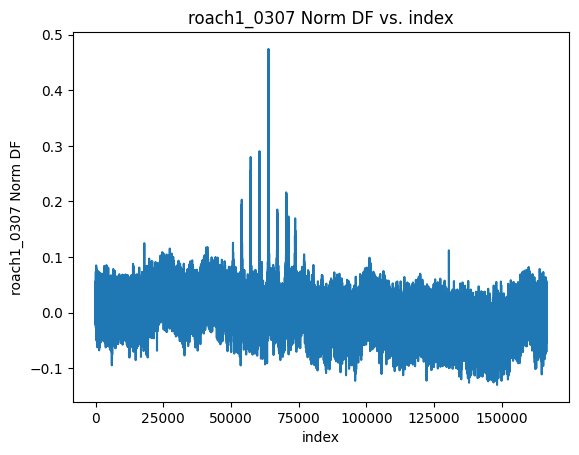

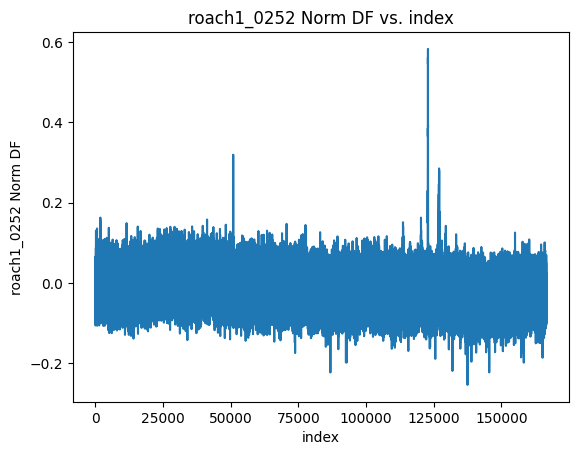

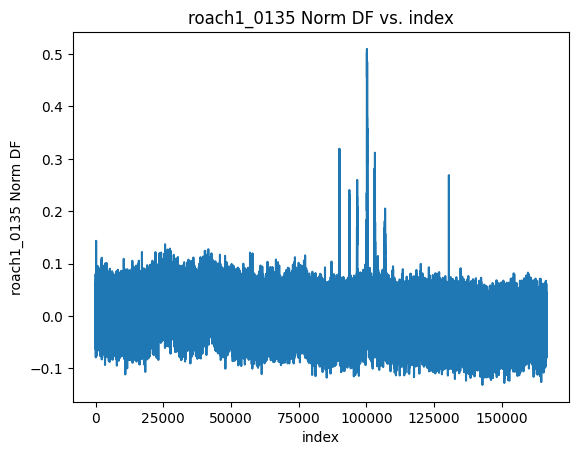

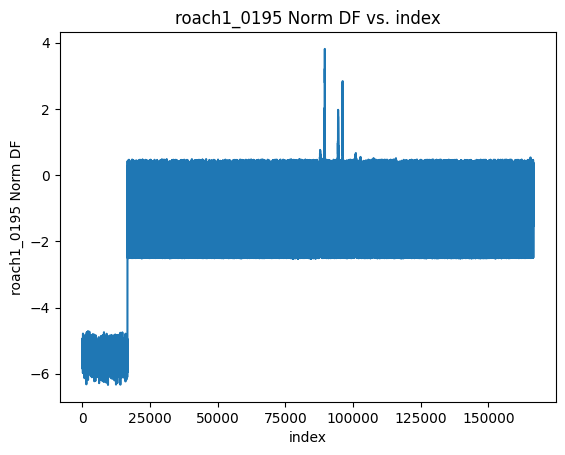

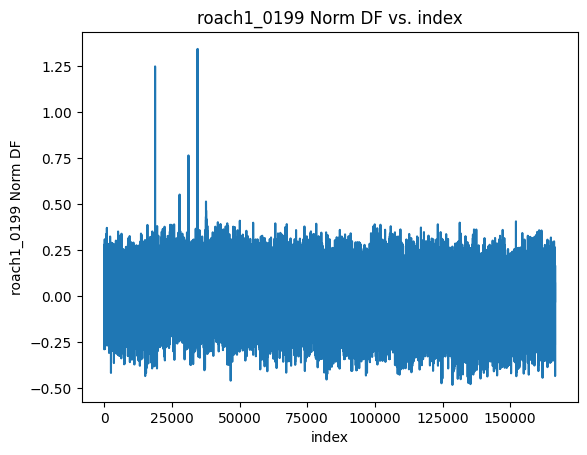

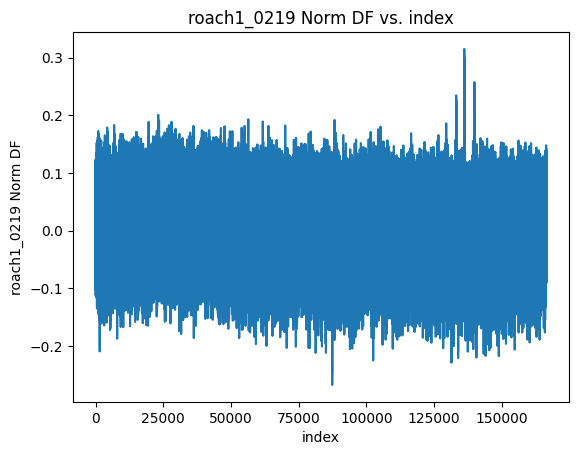

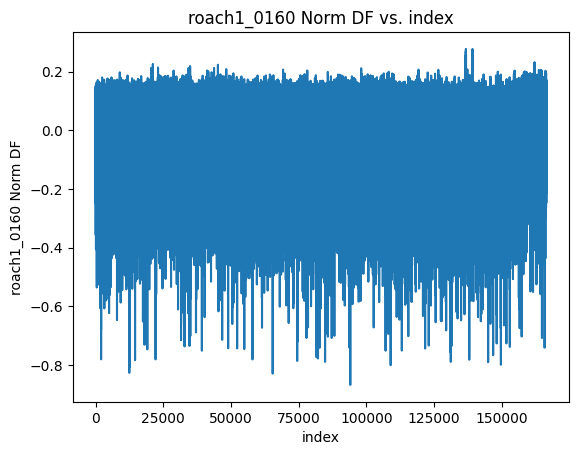

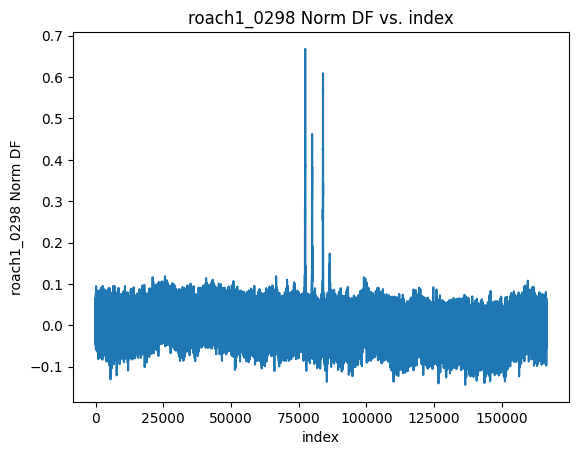

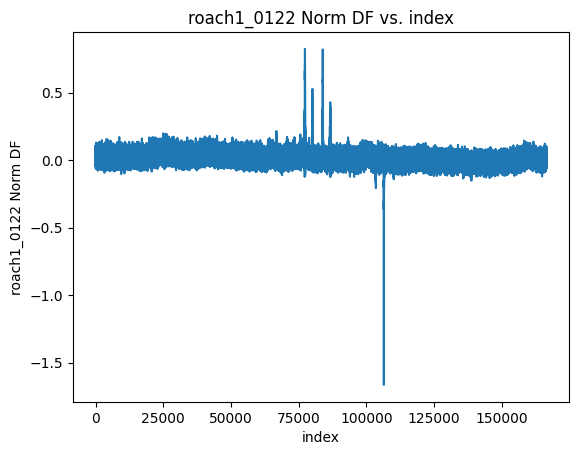

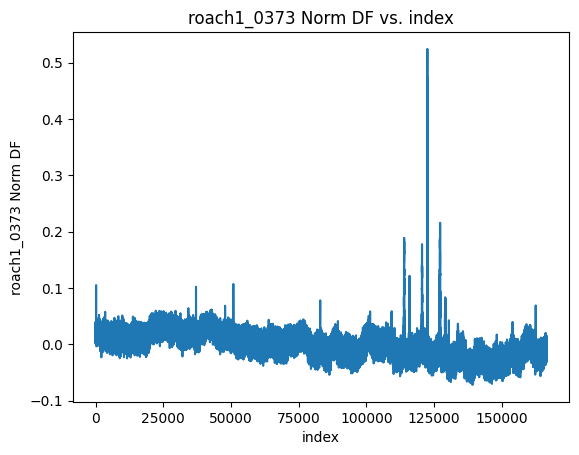

In [8]:
def kid_property(kid: str, key: str):
    """Get a function which pulls data for kid from G3SuperTimestream at frame[key]"""
    def get_kid_norm_df(frame):
        super_ts = frame[key]
        kid_idx = int(np.where(np.array(super_ts.names) == kid)[0][0])
        return np.array(super_ts.data[kid_idx])
    return get_kid_norm_df

kids: np.ndarray[str] = np.array(first_scan_frame["norm_df"].names)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(norm_df_added))
pipe.Add(ut.FrameCounter)
for kid in kids[:10]:
    # pipe.Add(ut.GenericPlotter, array_getter=kid_property(kid, "df"), label=f"{kid} DF")
    pipe.Add(ut.GenericPlotter, array_getter=kid_property(kid, "norm_df"), label=f"{kid} Norm DF")
    # pipe.Add(ut.GenericPlotter, array_getter=kid_property(kid+"_I", "data"), label=f"{kid} In-Phase (I) transmission")
    # pipe.Add(ut.GenericPlotter, array_getter=kid_property(kid+"_Q", "data"), label=f"{kid} Quadrature (Q) transmission")
pipe.Run()